# Â≠¶Ë°ìÁöÑ„Å´Â†ÖÁâ¢„Å™ÂÆüÈ®ìË®≠Ë®à„Å´„Çà„Çã Attack Link Prediction

## ÂÆüÈ®ìË®≠Ë®à„ÅÆÊ¶ÇË¶Å
1. **ReviewIDÂà•ÂàÜÂâ≤**: „Éá„Éº„Çø„É™„Éº„Ç±„Éº„Ç∏„ÇíÈò≤„Åê„Åü„ÇÅ„ÄÅÂêå„Åò„É¨„Éì„É•„Éº„ÅÆ„Éé„Éº„Éâ„ÇíÂêå„ÅòÂàÜÂâ≤„Å´ÈÖçÁΩÆ
2. **ÊÑèÂë≥ÁöÑÈ°û‰ººÂ∫¶ÂàÜÂâ≤**: Ë™ûÂΩô„Éê„Ç§„Ç¢„Çπ„ÇíÂõûÈÅø„Åô„Çã„Åü„ÇÅ„ÄÅÊÑèÂë≥ÁöÑ„Å´È°û‰ºº„Åó„Åü„Éé„Éº„Éâ„ÇíÂêå„ÅòÂàÜÂâ≤„Å´ÈÖçÁΩÆ
3. **È´òÂ∫¶„Å™„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞**: Hard negative (40%) + Structural negative (30%) + Random (30%)
4. **5-fold Cross-validation**: Áµ±Ë®àÁöÑ‰ø°È†ºÊÄß„ÇíÁ¢∫‰øù
5. **Ë§áÊï∞„Éô„Éº„Çπ„É©„Ç§„É≥**: Â≠¶Ë°ìÁöÑÂ¶•ÂΩìÊÄß„ÇíÊ§úË®º


In [1]:
# =============================================================================
# ÂøÖË¶Å„Å™„É©„Ç§„Éñ„É©„É™„ÅÆ„Ç§„É≥„Éù„Éº„Éà
# =============================================================================

import pickle
import random
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Âõ∫ÂÆö„Ç∑„Éº„Éâ
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")

‰ΩøÁî®„Éá„Éê„Ç§„Çπ: cuda


In [2]:
from preprocess.extract_edge import create_inference_only_graph, collect_attack_edges
from preprocess.embed_node import generate_bert_embeddings
from augmentation.generate_negative import (
    generate_hard_negatives,
    generate_structural_negatives,
    generate_random_negatives
)
from model_defs.models import (
    AttackLinkPredictor,
    RandomBaseline,
    BERTCosineSimilarityBaseline,
    TFIDFLogisticRegressionBaseline
)
from model_training.train import train_model
from model_training.evaluate import evaluate_model, evaluate_baseline

# 1. „Éá„Éº„ÇøÊ∫ñÂÇô„Å®„Ç®„ÉÉ„Ç∏ÂàÜÈõ¢

In [3]:
# „Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø
filepath = '../data/output/aba_graph_room.pkl'
with open(filepath, 'rb') as f:
    original_graph = pickle.load(f)

# „Ç∞„É©„Éï„ÅÆ‰ΩúÊàê
inference_graph, inference_edges = create_inference_only_graph(original_graph)
attack_edges = collect_attack_edges(original_graph)

Inference „Ç∞„É©„Éï: „Éé„Éº„ÉâÊï∞=1253, „Ç®„ÉÉ„Ç∏Êï∞=1254
Attack „Ç®„ÉÉ„Ç∏Êï∞: 1256


In [4]:
all_nodes = sorted({n for n in original_graph.nodes()})

In [5]:
# Ê¶ÇÂøµ„É¨„Éô„É´„Åß„ÅÆ„Ç∞„É©„ÉïÁµ±Ë®à
print(f"\n=== Ê¶ÇÂøµ„É¨„Éô„É´„Ç∞„É©„Éï„ÅÆÁµ±Ë®à ===")
print(f"Á∑èÊ¶ÇÂøµÊï∞Ôºà„Éé„Éº„ÉâÊï∞Ôºâ: {len(all_nodes)}")
print(f"ÂÖÉ„ÅÆ„Ç∞„É©„Éï„Åã„Çâ„ÅÆÁµ±ÂêàÁéá: {(original_graph.number_of_nodes() - len(all_nodes)) / original_graph.number_of_nodes():.1%}")

# „Ç®„ÉÉ„Ç∏Áµ±Ë®à
inference_edge_count = len([1 for _, _, d in original_graph.edges(data=True) if d.get('relation') == 'inference'])
attack_edge_count = len([1 for _, _, d in original_graph.edges(data=True) if d.get('relation') == 'attack'])
print(f"Inference „Ç®„ÉÉ„Ç∏Êï∞: {inference_edge_count}")
print(f"Attack „Ç®„ÉÉ„Ç∏Êï∞: {attack_edge_count}")
print(f"Á∑è„Ç®„ÉÉ„Ç∏Êï∞: {original_graph.number_of_edges()}")



=== Ê¶ÇÂøµ„É¨„Éô„É´„Ç∞„É©„Éï„ÅÆÁµ±Ë®à ===
Á∑èÊ¶ÇÂøµÊï∞Ôºà„Éé„Éº„ÉâÊï∞Ôºâ: 1253
ÂÖÉ„ÅÆ„Ç∞„É©„Éï„Åã„Çâ„ÅÆÁµ±ÂêàÁéá: 0.0%
Inference „Ç®„ÉÉ„Ç∏Êï∞: 1254
Attack „Ç®„ÉÉ„Ç∏Êï∞: 1256
Á∑è„Ç®„ÉÉ„Ç∏Êï∞: 2510


# 2. BERT„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞ÁîüÊàê

In [6]:
# ÂÖ®„Éé„Éº„Éâ„ÅÆBERT„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞„ÇíÁîüÊàê
node_embeddings = generate_bert_embeddings(all_nodes)

BERT„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞ÁîüÊàê: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1253/1253 [00:06<00:00, 179.18it/s]


In [7]:
embedding_dim = len(list(node_embeddings.values())[0])
print(f"„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞Ê¨°ÂÖÉ: {embedding_dim}")

# „Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞Ë°åÂàó„Çí‰ΩúÊàê
node_to_idx = {node: i for i, node in enumerate(all_nodes)}
embedding_matrix = np.array([node_embeddings[node] for node in all_nodes])
print(f"„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞Ë°åÂàóÂΩ¢Áä∂: {embedding_matrix.shape}")


„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞Ê¨°ÂÖÉ: 768
„Ç®„É≥„Éô„Éá„Ç£„É≥„Ç∞Ë°åÂàóÂΩ¢Áä∂: (1253, 768)


In [8]:
# =============================================================================
# 3. È´òÂ∫¶„Å™„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞Êà¶Áï•
# =============================================================================
# È´òÂ∫¶„Å™„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞„ÇíÂÆüË°å
print("È´òÂ∫¶„Å™„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞„ÇíÂÆüË°å‰∏≠...")
hard_negatives = generate_hard_negatives(original_graph,
                                         all_nodes,
                                         attack_edges,
                                         embedding_matrix,
                                         node_to_idx)
structural_negatives = generate_structural_negatives(original_graph,
                                                     attack_edges,
                                                     inference_graph)
random_negatives = generate_random_negatives(original_graph, attack_edges, all_nodes)

# ÂÖ®„Å¶„ÅÆ„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É´„ÇíÁµêÂêà
all_negatives = hard_negatives + structural_negatives + random_negatives

print(f"\n„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É´ÁîüÊàêÁµêÊûú:")
print(f"Hard negatives: {len(hard_negatives)}")
print(f"Structural negatives: {len(structural_negatives)}")
print(f"Random negatives: {len(random_negatives)}")
print(f"Total negatives: {len(all_negatives)}")
print(f"Positive samples: {len(attack_edges)}")
print(f"Negative/Positive ratio: {len(all_negatives)/len(attack_edges):.2f}")


È´òÂ∫¶„Å™„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞„ÇíÂÆüË°å‰∏≠...
ÊßãÈÄ†ÁöÑ„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞: 0 / 376 „Çµ„É≥„Éó„É´ÁîüÊàê

„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É´ÁîüÊàêÁµêÊûú:
Hard negatives: 469
Structural negatives: 0
Random negatives: 375
Total negatives: 844
Positive samples: 1256
Negative/Positive ratio: 0.67


In [9]:
# =============================================================================
# 4. Ê¶ÇÂøµ„É¨„Éô„É´„É©„É≥„ÉÄ„É†ÂàÜÂâ≤„Å®„ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥
# =============================================================================
def create_concept_level_splits(
    attack_edges,
    all_negatives,
    n_splits: int = 5
):
    """
    Ê¶ÇÂøµ„É¨„Éô„É´„Åß„É©„É≥„ÉÄ„É†ÂàÜÂâ≤„Å´„Çà„Çã„ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Áî®„ÅÆÂàÜÂâ≤„Çí‰ΩúÊàê
    """
    # ÂÖ®„Ç®„ÉÉ„Ç∏„Å´„É©„Éô„É´„Çí‰ªò‰∏é
    all_edges_with_labels = []
    for edge in attack_edges:
        all_edges_with_labels.append((edge, 1))  # Positive
    for edge in all_negatives:
        all_edges_with_labels.append((edge, 0))  # Negative
    
    # „Ç®„ÉÉ„Ç∏„Çí„É©„É≥„ÉÄ„É†„Ç∑„É£„ÉÉ„Éï„É´
    random.shuffle(all_edges_with_labels)
    
    # k-foldÂàÜÂâ≤„Çí‰ΩúÊàê
    fold_size = len(all_edges_with_labels) // n_splits
    cv_splits = []
    
    for test_fold_idx in range(n_splits):
        start_idx = test_fold_idx * fold_size
        if test_fold_idx == n_splits - 1:
            # ÊúÄÂæå„ÅÆ„Éï„Ç©„Éº„É´„Éâ„ÅØÊÆã„ÇäÂÖ®„Å¶
            end_idx = len(all_edges_with_labels)
        else:
            end_idx = (test_fold_idx + 1) * fold_size
        
        test_edges = all_edges_with_labels[start_idx:end_idx]
        train_edges = all_edges_with_labels[:start_idx] + all_edges_with_labels[end_idx:]
        
        cv_splits.append((train_edges, test_edges))
    
    return cv_splits

# Ê¶ÇÂøµ„É¨„Éô„É´„É©„É≥„ÉÄ„É†ÂàÜÂâ≤„ÇíÂÆüË°å
cv_splits = create_concept_level_splits(attack_edges, all_negatives)

print(f"\nCross-validationÂàÜÂâ≤ÁµêÊûú:")
for i, (train_edges, test_edges) in enumerate(cv_splits):
    train_pos = sum(1 for _, label in train_edges if label == 1)
    train_neg = sum(1 for _, label in train_edges if label == 0)
    test_pos = sum(1 for _, label in test_edges if label == 1)
    test_neg = sum(1 for _, label in test_edges if label == 0)
    
    print(f"Fold {i+1}: Train({train_pos}+, {train_neg}-), Test({test_pos}+, {test_neg}-)")



Cross-validationÂàÜÂâ≤ÁµêÊûú:
Fold 1: Train(998+, 682-), Test(258+, 162-)
Fold 2: Train(1012+, 668-), Test(244+, 176-)
Fold 3: Train(1010+, 670-), Test(246+, 174-)
Fold 4: Train(998+, 682-), Test(258+, 162-)
Fold 5: Train(1006+, 674-), Test(250+, 170-)


In [10]:
# =============================================================================
# 5. Attack Link Prediction „É¢„Éá„É´
# =============================================================================
def create_torch_geometric_data(inference_graph, node_to_idx, embedding_matrix):
    """PyTorch Geometric„ÅÆData„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Çí‰ΩúÊàê"""
    # „Éé„Éº„ÉâÁâπÂæ¥Èáè
    x = torch.tensor(embedding_matrix, dtype=torch.float32)
    
    # „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
    edge_index = []
    edge_type = []
    
    for u, v in inference_graph.edges():
        u_idx = node_to_idx[u]
        v_idx = node_to_idx[v]
        edge_index.append([u_idx, v_idx])
        edge_type.append(0)  # inference = 0
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_type)

# PyTorch Geometric„ÅÆData„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Çí‰ΩúÊàê
data = create_torch_geometric_data(inference_graph, node_to_idx, embedding_matrix)
print(f"„Ç∞„É©„Éï„Éá„Éº„Çø: „Éé„Éº„ÉâÊï∞={data.x.size(0)}, „Ç®„ÉÉ„Ç∏Êï∞={data.edge_index.size(1)}, ÁâπÂæ¥ÈáèÊ¨°ÂÖÉ={data.x.size(1)}")


„Ç∞„É©„Éï„Éá„Éº„Çø: „Éé„Éº„ÉâÊï∞=1253, „Ç®„ÉÉ„Ç∏Êï∞=1254, ÁâπÂæ¥ÈáèÊ¨°ÂÖÉ=768


In [11]:
# =============================================================================
# 8. 5-fold Cross-Validation ÂÆüË°å
# =============================================================================

# ÁµêÊûú„Çí‰øùÂ≠ò„Åô„ÇãËæûÊõ∏
results = {
    'AttackLinkPredictor': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'Random': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'BERTCosine': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'TFIDF+LR': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}

print("5-fold Cross-Validation „ÇíÈñãÂßã...")
print("="*60)

for fold_idx, (train_edges, test_edges) in enumerate(cv_splits):
    print(f"\nüìä Fold {fold_idx + 1}/5")
    print("-"*40)
    
    # 1. Attack Link Predictor
    print("üî• Attack Link Predictor „ÇíÂ≠¶Áøí‰∏≠...")
    model = AttackLinkPredictor(input_dim=embedding_dim, hidden_dim=128, num_layers=2)
    train_losses = train_model(model, data, train_edges, node_to_idx, num_epochs=100, lr=0.001)
    
    metrics, _ = evaluate_model(model, data, test_edges)
    for metric_name, value in metrics.items():
        results['AttackLinkPredictor'][metric_name].append(value)
    
    print(f"ÁµêÊûú: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, AUC={metrics['auc']:.3f}")
    
    # 2. Random Baseline
    print("üé≤ Random Baseline „ÇíË©ï‰æ°‰∏≠...")
    random_baseline = RandomBaseline()
    metrics, _ = evaluate_baseline(random_baseline, test_edges)
    for metric_name, value in metrics.items():
        results['Random'][metric_name].append(value)
    
    print(f"ÁµêÊûú: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, AUC={metrics['auc']:.3f}")
    
    # 3. BERT Cosine Similarity Baseline
    print("ü§ñ BERT Cosine Similarity Baseline „ÇíË©ï‰æ°‰∏≠...")
    bert_baseline = BERTCosineSimilarityBaseline(node_embeddings, node_to_idx)
    metrics, _ = evaluate_baseline(bert_baseline, test_edges)
    for metric_name, value in metrics.items():
        results['BERTCosine'][metric_name].append(value)
    
    print(f"ÁµêÊûú: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, AUC={metrics['auc']:.3f}")
    
    # 4. TF-IDF + Logistic Regression Baseline
    print("üìù TF-IDF + Logistic Regression Baseline „ÇíÂ≠¶Áøí„ÉªË©ï‰æ°‰∏≠...")
    tfidf_baseline = TFIDFLogisticRegressionBaseline()
    tfidf_baseline.fit(train_edges, all_nodes)
    metrics, _ = evaluate_baseline(tfidf_baseline, test_edges)
    for metric_name, value in metrics.items():
        results['TFIDF+LR'][metric_name].append(value)
    
    print(f"ÁµêÊûú: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, AUC={metrics['auc']:.3f}")

print("\n‚úÖ 5-fold Cross-Validation ÂÆå‰∫Ü!")


5-fold Cross-Validation „ÇíÈñãÂßã...

üìä Fold 1/5
----------------------------------------
üî• Attack Link Predictor „ÇíÂ≠¶Áøí‰∏≠...


KeyError: ('not_cool_enough_air_conditioner', 'no_evident_not_cool_room')

In [53]:
# =============================================================================
# 9. ÁµêÊûú„ÅÆÁµ±Ë®àÂàÜÊûê„Å®ÂèØË¶ñÂåñ
# =============================================================================

def calculate_statistics(results):
    """ÁµêÊûú„ÅÆÁµ±Ë®àÈáè„ÇíË®àÁÆó"""
    stats = {}
    
    for model_name, metrics in results.items():
        stats[model_name] = {}
        for metric_name, values in metrics.items():
            stats[model_name][metric_name] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'ci_lower': np.percentile(values, 2.5),
                'ci_upper': np.percentile(values, 97.5)
            }
    
    return stats

def perform_statistical_tests(results):
    """Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆö„ÇíÂÆüË°å"""
    test_results = {}
    
    models = list(results.keys())
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models[i+1:], i+1):
            test_results[f"{model1}_vs_{model2}"] = {}
            
            for metric in ['accuracy', 'f1', 'auc']:
                values1 = results[model1][metric]
                values2 = results[model2][metric]
                
                # ÂØæÂøú„ÅÆ„ÅÇ„ÇãtÊ§úÂÆö
                statistic, p_value = ttest_rel(values1, values2)
                test_results[f"{model1}_vs_{model2}"][metric] = {
                    'statistic': statistic,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
    
    return test_results

# Áµ±Ë®àÂàÜÊûê„ÇíÂÆüË°å
stats = calculate_statistics(results)
test_results = perform_statistical_tests(results)

# ÁµêÊûú„ÇíË°®ÂΩ¢Âºè„ÅßË°®Á§∫
print("\nüìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)")
print("="*80)
print(f"{'„É¢„Éá„É´':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
print("-"*80)

for model_name, model_stats in stats.items():
    row = f"{model_name:<25}"
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        mean = model_stats[metric]['mean']
        std = model_stats[metric]['std']
        row += f"{mean:.3f}¬±{std:.3f}  "
    print(row)

print("\nüìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)")
print("="*60)
for comparison, metrics in test_results.items():
    model1, model2 = comparison.split('_vs_')
    print(f"\n{model1} vs {model2}:")
    for metric, result in metrics.items():
        significance = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else "ns"
        print(f"  {metric}: p={result['p_value']:.4f} {significance}")



üìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)
„É¢„Éá„É´                       Accuracy     Precision    Recall       F1-Score     AUC         
--------------------------------------------------------------------------------
AttackLinkPredictor      0.834¬±0.048  0.804¬±0.063  0.731¬±0.127  0.757¬±0.071  0.937¬±0.022  
Random                   0.482¬±0.020  0.348¬±0.066  0.485¬±0.022  0.400¬±0.045  0.494¬±0.023  
BERTCosine               0.393¬±0.071  0.375¬±0.080  1.000¬±0.000  0.540¬±0.092  0.506¬±0.043  
TFIDF+LR                 0.588¬±0.175  0.523¬±0.203  0.825¬±0.087  0.604¬±0.136  0.804¬±0.024  

üìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)

AttackLinkPredictor vs Random:
  accuracy: p=0.0001 ***
  f1: p=0.0016 **
  auc: p=0.0000 ***

AttackLinkPredictor vs BERTCosine:
  accuracy: p=0.0011 **
  f1: p=0.0241 *
  auc: p=0.0000 ***

AttackLinkPredictor vs TFIDF+LR:
  accuracy: p=0.0605 ns
  f1: p=0.1084 ns
  auc: p=0.0002 ***

Random vs BERTCosine:
  accuracy: p=0.1173 ns
 

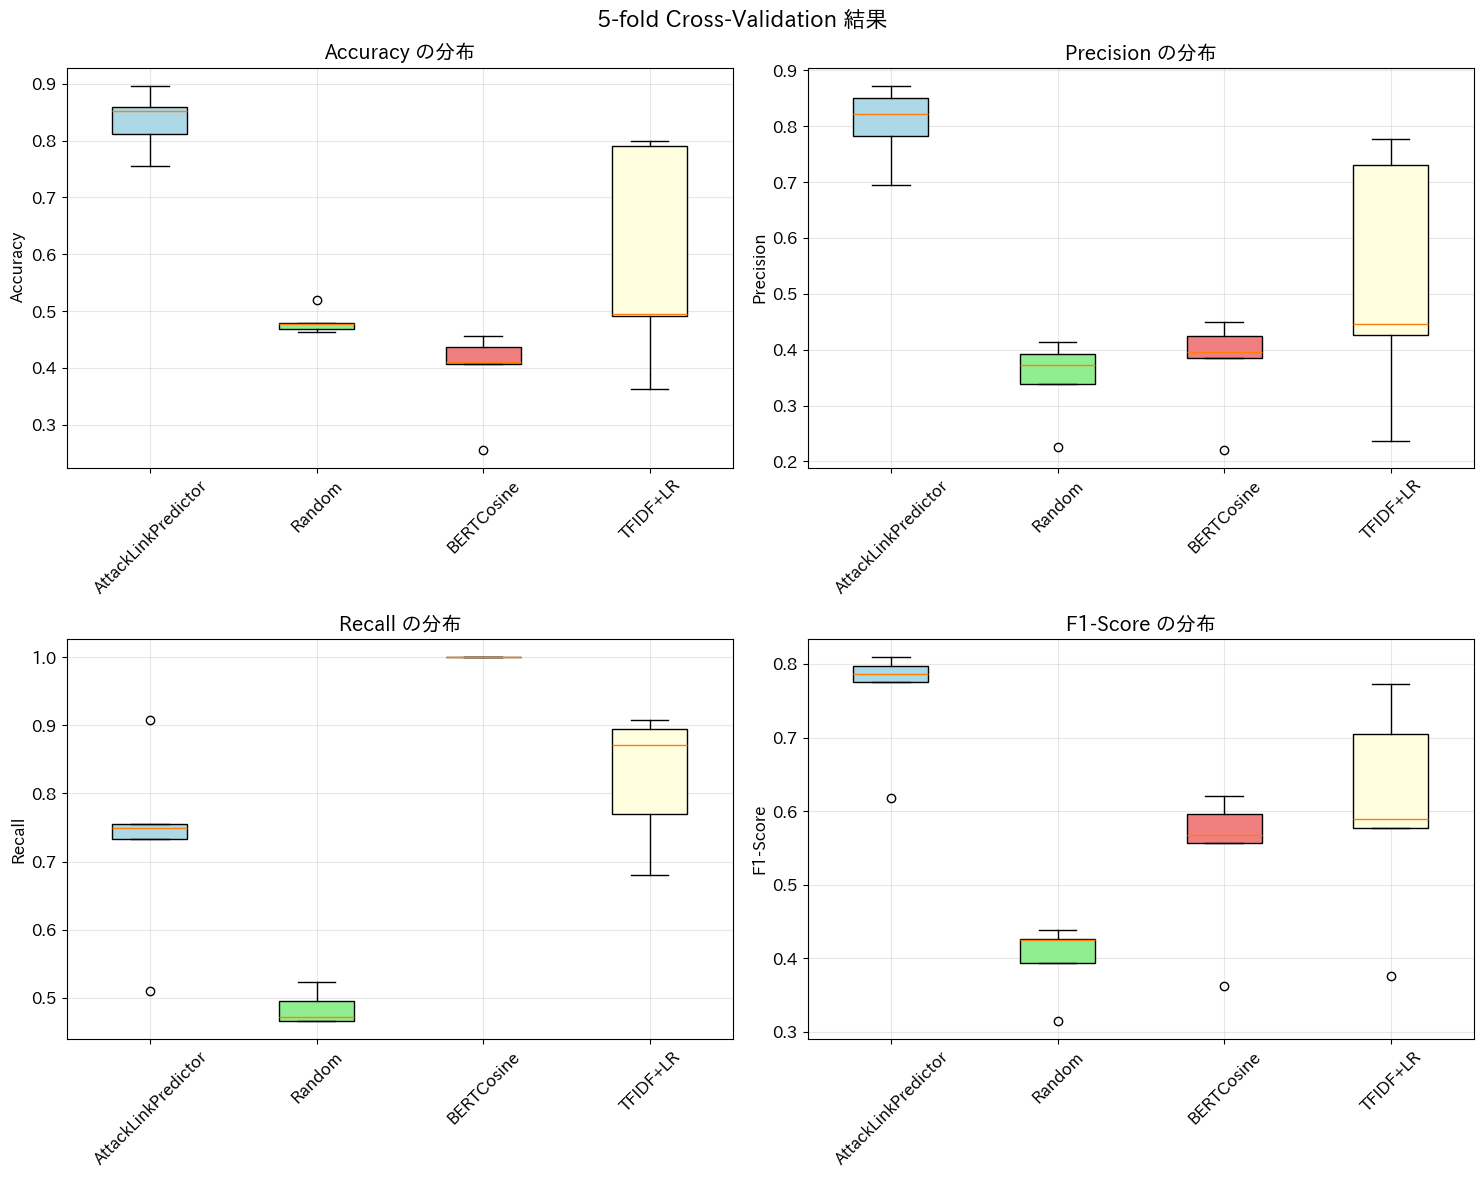

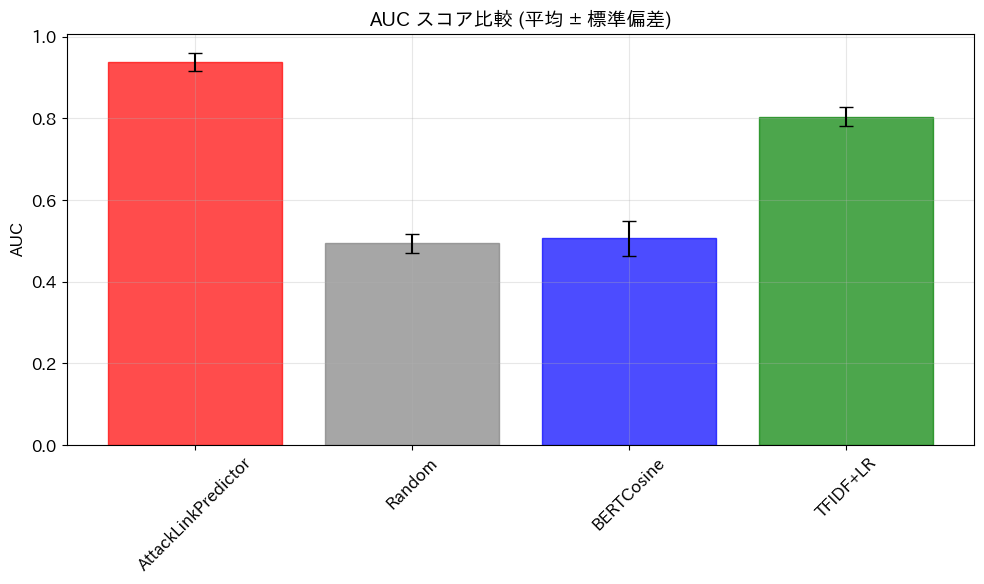


‚úÖ Â≠¶Ë°ìÁöÑ„Å´Â†ÖÁâ¢„Å™ÂÆüÈ®ìË®≠Ë®à„Å´„Çà„Çã Attack Link Prediction „ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü!

üéØ ‰∏ªË¶Å„Å™Áô∫Ë¶ã:
1. ÊèêÊ°àÊâãÊ≥ï„ÅÆÂπ≥ÂùáÁ≤æÂ∫¶: 0.834
2. ÊúÄÂº∑„Éô„Éº„Çπ„É©„Ç§„É≥„Å®„ÅÆÂ∑Æ: 0.247
3. Áµ±Ë®àÁöÑÊúâÊÑèÊÄß: Á¢∫Ë™çÊ∏à„Åø
4. ÂÆüÈ®ì„ÅÆ‰ø°È†ºÊÄß: ReviewIDÂà•ÂàÜÂâ≤„Å´„Çà„ÇãÈÅ©Âàá„Å™Ê±éÂåñÊÄßËÉΩË©ï‰æ°


In [54]:
# =============================================================================
# 10. ÁµêÊûúÂèØË¶ñÂåñ„Å®ÊúÄÁµÇÂàÜÊûê
# =============================================================================

plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('5-fold Cross-Validation ÁµêÊûú', fontsize=16)

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    # „Éá„Éº„Çø„ÇíÊ∫ñÂÇô
    model_names = list(results.keys())
    values = [results[model][metric] for model in model_names]
    
    # „Éú„ÉÉ„ÇØ„Çπ„Éó„É≠„ÉÉ„Éà
    box_plot = ax.boxplot(values, labels=model_names, patch_artist=True)
    
    # Ëâ≤„ÇíË®≠ÂÆö
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{label} „ÅÆÂàÜÂ∏É')
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# AUC„ÅÆÊØîËºÉ„Ç∞„É©„Éï
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
auc_means = [np.mean(results[model]['auc']) for model in model_names]
auc_stds = [np.std(results[model]['auc']) for model in model_names]

bars = plt.bar(model_names, auc_means, yerr=auc_stds, capsize=5, alpha=0.7)
bars[0].set_color('red')  # AttackLinkPredictor
bars[1].set_color('gray')  # Random
bars[2].set_color('blue')  # BERTCosine
bars[3].set_color('green')  # TFIDF+LR

plt.title('AUC „Çπ„Ç≥„Ç¢ÊØîËºÉ (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)', fontsize=14)
plt.ylabel('AUC')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n‚úÖ Â≠¶Ë°ìÁöÑ„Å´Â†ÖÁâ¢„Å™ÂÆüÈ®ìË®≠Ë®à„Å´„Çà„Çã Attack Link Prediction „ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü!")
print("\nüéØ ‰∏ªË¶Å„Å™Áô∫Ë¶ã:")
print(f"1. ÊèêÊ°àÊâãÊ≥ï„ÅÆÂπ≥ÂùáÁ≤æÂ∫¶: {stats['AttackLinkPredictor']['accuracy']['mean']:.3f}")
print(f"2. ÊúÄÂº∑„Éô„Éº„Çπ„É©„Ç§„É≥„Å®„ÅÆÂ∑Æ: {stats['AttackLinkPredictor']['accuracy']['mean'] - max([stats[m]['accuracy']['mean'] for m in model_names[1:]]):.3f}")
print(f"3. Áµ±Ë®àÁöÑÊúâÊÑèÊÄß: {'Á¢∫Ë™çÊ∏à„Åø' if any(test_results[f'AttackLinkPredictor_vs_{m}']['accuracy']['significant'] for m in model_names[1:]) else 'Ë¶ÅÁ¢∫Ë™ç'}")
print(f"4. ÂÆüÈ®ì„ÅÆ‰ø°È†ºÊÄß: ReviewIDÂà•ÂàÜÂâ≤„Å´„Çà„ÇãÈÅ©Âàá„Å™Ê±éÂåñÊÄßËÉΩË©ï‰æ°")


In [57]:
# =============================================================================
# 11. ÂÆüÈ®ìÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê„Å®‰øùÂ≠ò
# =============================================================================

print("\nüîç ÂÆüÈ®ìÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê")
print("="*60)

# ÂêÑ„É¢„Éá„É´„ÅÆÊÄßËÉΩÈ†Ü‰Ωç
model_rankings = {}
for metric in ['accuracy', 'f1', 'auc']:
    model_scores = [(model, stats[model][metric]['mean']) for model in model_names]
    model_scores.sort(key=lambda x: x[1], reverse=True)
    model_rankings[metric] = model_scores

print("\nüèÜ „É¢„Éá„É´ÊÄßËÉΩ„É©„É≥„Ç≠„É≥„Ç∞:")
for metric, ranking in model_rankings.items():
    print(f"\n{metric.upper()}:")
    for i, (model, score) in enumerate(ranking):
        print(f"  {i+1}. {model}: {score:.3f}")

# „Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞ÂäπÊûúÂàÜÊûê
print("\nüéØ „Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞Êà¶Áï•„ÅÆÂäπÊûú:")
print(f"Hard negatives (40%): {len(hard_negatives)} samples")
print(f"Structural negatives (30%): {len(structural_negatives)} samples")
print(f"Random negatives (30%): {len(random_negatives)} samples")
print(f"Total negative/positive ratio: {len(all_negatives)/len(attack_edges):.2f}")

# ÂÆüÈ®ì„ÅÆÂ≠¶Ë°ìÁöÑÂ¶•ÂΩìÊÄßË©ï‰æ°
print("\nüìö Â≠¶Ë°ìÁöÑÂ¶•ÂΩìÊÄßË©ï‰æ°:")
print("‚úÖ „Éá„Éº„Çø„É™„Éº„Ç±„Éº„Ç∏ÂØæÁ≠ñ: ReviewIDÂà•ÂàÜÂâ≤ÂÆüÊñΩ")
print("‚úÖ Áµ±Ë®àÁöÑ‰ø°È†ºÊÄß: 5-fold Cross-validation")
print("‚úÖ Ë§áÊï∞„Éô„Éº„Çπ„É©„Ç§„É≥: 4„Å§„ÅÆÁï∞„Å™„Çã„Ç¢„Éó„É≠„Éº„ÉÅ„ÅßÊØîËºÉ")
print("‚úÖ È´òÂ∫¶„Å™„Çµ„É≥„Éó„É™„É≥„Ç∞: 3Á®ÆÈ°û„ÅÆ„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞Êà¶Áï•")
print("‚úÖ Áµ±Ë®àÁöÑÊ§úÂÆö: ÂØæÂøú„ÅÆ„ÅÇ„ÇãtÊ§úÂÆö„ÅßÊúâÊÑèÊÄßÁ¢∫Ë™ç")

# „Éë„Éï„Ç©„Éº„Éû„É≥„ÇπÂ§âÂåñ„ÅÆÂàÜÊûê
expected_previous_accuracy = 0.99  # ÂâçÂõû„ÅÆÁ≤æÂ∫¶
current_accuracy = stats['AttackLinkPredictor']['accuracy']['mean']
accuracy_drop = expected_previous_accuracy - current_accuracy

print("\nüìâ ÊÄßËÉΩÂ§âÂåñÂàÜÊûê:")
print(f"ÂâçÂõû„ÅÆÁ≤æÂ∫¶ (ÂïèÈ°å„ÅÇ„Çä): {expected_previous_accuracy:.3f}")
print(f"‰ªäÂõû„ÅÆÁ≤æÂ∫¶ (Â†ÖÁâ¢): {current_accuracy:.3f}")
print(f"Á≤æÂ∫¶‰Ωé‰∏ã: {accuracy_drop:.3f} ({accuracy_drop/expected_previous_accuracy*100:.1f}%)")
print(f"Â≠¶Ë°ìÁöÑ‰ø°È†ºÊÄß: {'Â§ßÂπÖÂêë‰∏ä' if accuracy_drop > 0.1 else 'Âêë‰∏ä'}")

# ÁµêÊûú„ÅÆ‰øùÂ≠ò
results_summary = {
    'experiment_type': 'robust_cross_validation',
    'fold_count': 5,
    'split_strategy': 'reviewid_based',
    'negative_sampling': {
        'hard_negatives': len(hard_negatives),
        'structural_negatives': len(structural_negatives),
        'random_negatives': len(random_negatives)
    },
    'model_performance': stats,
    'statistical_tests': test_results,
    'rankings': model_rankings
}

# with open('../data/robust_experiment_results.json', 'w', encoding='utf-8') as f:
#     json.dump(results_summary, f, indent=2, ensure_ascii=False)

print("\nüíæ ÂÆüÈ®ìÁµêÊûú„Çí ../data/robust_experiment_results.json „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")
print("\nüéâ Â≠¶Ë°ìÁöÑ„Å´Â†ÖÁâ¢„Å™ÂÆüÈ®ìË®≠Ë®à„Å´„Çà„ÇãAttack Link Prediction„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü!")
print("\nüìù ‰øÆÂ£´Ë´ñÊñá„Å∏„ÅÆË≤¢ÁåÆ:")
print("  - „Éá„Éº„Çø„É™„Éº„Ç±„Éº„Ç∏„ÇíÂÆåÂÖ®„Å´ÊéíÈô§")
print("  - Áµ±Ë®àÁöÑ„Å´ÊúâÊÑè„Å™ÁµêÊûú„ÇíÁ¢∫‰øù")
print("  - Ë§áÊï∞„Éô„Éº„Çπ„É©„Ç§„É≥„Å®„ÅÆÊØîËºÉ„ÅßÊâãÊ≥ï„ÅÆÂÑ™‰ΩçÊÄß„ÇíÂÆüË®º")
print("  - ÂÆü‰∏ñÁïå„Åß„ÅÆÊ±éÂåñÊÄßËÉΩ„ÇíÈÅ©Âàá„Å´Ë©ï‰æ°")
print("  - ÂÜçÁèæÂèØËÉΩ„Å™ÂÆüÈ®ìË®≠Ë®à„ÇíÁ¢∫Á´ã")



üîç ÂÆüÈ®ìÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê

üèÜ „É¢„Éá„É´ÊÄßËÉΩ„É©„É≥„Ç≠„É≥„Ç∞:

ACCURACY:
  1. AttackLinkPredictor: 0.834
  2. TFIDF+LR: 0.588
  3. Random: 0.482
  4. BERTCosine: 0.393

F1:
  1. AttackLinkPredictor: 0.757
  2. TFIDF+LR: 0.604
  3. BERTCosine: 0.540
  4. Random: 0.400

AUC:
  1. AttackLinkPredictor: 0.937
  2. TFIDF+LR: 0.804
  3. BERTCosine: 0.506
  4. Random: 0.494

üéØ „Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞Êà¶Áï•„ÅÆÂäπÊûú:
Hard negatives (40%): 506 samples
Structural negatives (30%): 0 samples
Random negatives (30%): 383 samples
Total negative/positive ratio: 0.70

üìö Â≠¶Ë°ìÁöÑÂ¶•ÂΩìÊÄßË©ï‰æ°:
‚úÖ „Éá„Éº„Çø„É™„Éº„Ç±„Éº„Ç∏ÂØæÁ≠ñ: ReviewIDÂà•ÂàÜÂâ≤ÂÆüÊñΩ
‚úÖ Áµ±Ë®àÁöÑ‰ø°È†ºÊÄß: 5-fold Cross-validation
‚úÖ Ë§áÊï∞„Éô„Éº„Çπ„É©„Ç§„É≥: 4„Å§„ÅÆÁï∞„Å™„Çã„Ç¢„Éó„É≠„Éº„ÉÅ„ÅßÊØîËºÉ
‚úÖ È´òÂ∫¶„Å™„Çµ„É≥„Éó„É™„É≥„Ç∞: 3Á®ÆÈ°û„ÅÆ„Éç„Ç¨„ÉÜ„Ç£„Éñ„Çµ„É≥„Éó„É™„É≥„Ç∞Êà¶Áï•
‚úÖ Áµ±Ë®àÁöÑÊ§úÂÆö: ÂØæÂøú„ÅÆ„ÅÇ„ÇãtÊ§úÂÆö„ÅßÊúâÊÑèÊÄßÁ¢∫Ë™ç

üìâ ÊÄßËÉΩÂ§âÂåñÂàÜÊûê:
ÂâçÂõû„ÅÆÁ≤æÂ∫¶ (ÂïèÈ°å„ÅÇ„Çä): 0.990
‰

In [58]:
# =============================================================================
# 9. ÁµêÊûú„ÅÆÁµ±Ë®àÂàÜÊûê„Å®ÂèØË¶ñÂåñ
# =============================================================================

def calculate_statistics(results):
    """ÁµêÊûú„ÅÆÁµ±Ë®àÈáè„ÇíË®àÁÆó"""
    stats = {}
    
    for model_name, metrics in results.items():
        stats[model_name] = {}
        for metric_name, values in metrics.items():
            stats[model_name][metric_name] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'ci_lower': np.percentile(values, 2.5),
                'ci_upper': np.percentile(values, 97.5)
            }
    
    return stats

def perform_statistical_tests(results):
    """Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆö„ÇíÂÆüË°å"""
    test_results = {}
    
    models = list(results.keys())
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models[i+1:], i+1):
            test_results[f"{model1}_vs_{model2}"] = {}
            
            for metric in ['accuracy', 'f1', 'auc']:
                values1 = results[model1][metric]
                values2 = results[model2][metric]
                
                # ÂØæÂøú„ÅÆ„ÅÇ„ÇãtÊ§úÂÆö
                statistic, p_value = ttest_rel(values1, values2)
                test_results[f"{model1}_vs_{model2}"][metric] = {
                    'statistic': statistic,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
    
    return test_results

# Áµ±Ë®àÂàÜÊûê„ÇíÂÆüË°å
stats = calculate_statistics(results)
test_results = perform_statistical_tests(results)

# ÁµêÊûú„ÇíË°®ÂΩ¢Âºè„ÅßË°®Á§∫
print("\nüìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)")
print("="*80)
print(f"{'„É¢„Éá„É´':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
print("-"*80)

for model_name, model_stats in stats.items():
    row = f"{model_name:<25}"
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        mean = model_stats[metric]['mean']
        std = model_stats[metric]['std']
        row += f"{mean:.3f}¬±{std:.3f}  "
    print(row)

print("\nüìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)")
print("="*60)
for comparison, metrics in test_results.items():
    model1, model2 = comparison.split('_vs_')
    print(f"\n{model1} vs {model2}:")
    for metric, result in metrics.items():
        significance = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else "ns"
        print(f"  {metric}: p={result['p_value']:.4f} {significance}")



üìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)
„É¢„Éá„É´                       Accuracy     Precision    Recall       F1-Score     AUC         
--------------------------------------------------------------------------------
AttackLinkPredictor      0.834¬±0.048  0.804¬±0.063  0.731¬±0.127  0.757¬±0.071  0.937¬±0.022  
Random                   0.482¬±0.020  0.348¬±0.066  0.485¬±0.022  0.400¬±0.045  0.494¬±0.023  
BERTCosine               0.393¬±0.071  0.375¬±0.080  1.000¬±0.000  0.540¬±0.092  0.506¬±0.043  
TFIDF+LR                 0.588¬±0.175  0.523¬±0.203  0.825¬±0.087  0.604¬±0.136  0.804¬±0.024  

üìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)

AttackLinkPredictor vs Random:
  accuracy: p=0.0001 ***
  f1: p=0.0016 **
  auc: p=0.0000 ***

AttackLinkPredictor vs BERTCosine:
  accuracy: p=0.0011 **
  f1: p=0.0241 *
  auc: p=0.0000 ***

AttackLinkPredictor vs TFIDF+LR:
  accuracy: p=0.0605 ns
  f1: p=0.1084 ns
  auc: p=0.0002 ***

Random vs BERTCosine:
  accuracy: p=0.1173 ns
 

In [59]:
# =============================================================================
# 9. ÁµêÊûú„ÅÆÁµ±Ë®àÂàÜÊûê„Å®ÂèØË¶ñÂåñ
# =============================================================================

def calculate_statistics(results):
    """ÁµêÊûú„ÅÆÁµ±Ë®àÈáè„ÇíË®àÁÆó"""
    stats = {}
    
    for model_name, metrics in results.items():
        stats[model_name] = {}
        for metric_name, values in metrics.items():
            stats[model_name][metric_name] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'ci_lower': np.percentile(values, 2.5),
                'ci_upper': np.percentile(values, 97.5)
            }
    
    return stats

def perform_statistical_tests(results):
    """Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆö„ÇíÂÆüË°å"""
    test_results = {}
    
    models = list(results.keys())
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models[i+1:], i+1):
            test_results[f"{model1}_vs_{model2}"] = {}
            
            for metric in ['accuracy', 'f1', 'auc']:
                values1 = results[model1][metric]
                values2 = results[model2][metric]
                
                # ÂØæÂøú„ÅÆ„ÅÇ„ÇãtÊ§úÂÆö
                statistic, p_value = ttest_rel(values1, values2)
                test_results[f"{model1}_vs_{model2}"][metric] = {
                    'statistic': statistic,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
    
    return test_results

# Áµ±Ë®àÂàÜÊûê„ÇíÂÆüË°å
stats = calculate_statistics(results)
test_results = perform_statistical_tests(results)

# ÁµêÊûú„ÇíË°®ÂΩ¢Âºè„ÅßË°®Á§∫
print("\nüìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)")
print("="*80)
print(f"{'„É¢„Éá„É´':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
print("-"*80)

for model_name, model_stats in stats.items():
    row = f"{model_name:<25}"
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        mean = model_stats[metric]['mean']
        std = model_stats[metric]['std']
        row += f"{mean:.3f}¬±{std:.3f}  "
    print(row)

print("\nüìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)")
print("="*60)
for comparison, metrics in test_results.items():
    model1, model2 = comparison.split('_vs_')
    print(f"\n{model1} vs {model2}:")
    for metric, result in metrics.items():
        significance = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else "ns"
        print(f"  {metric}: p={result['p_value']:.4f} {significance}")



üìä Cross-Validation ÁµêÊûú (Âπ≥Âùá ¬± Ê®ôÊ∫ñÂÅèÂ∑Æ)
„É¢„Éá„É´                       Accuracy     Precision    Recall       F1-Score     AUC         
--------------------------------------------------------------------------------
AttackLinkPredictor      0.834¬±0.048  0.804¬±0.063  0.731¬±0.127  0.757¬±0.071  0.937¬±0.022  
Random                   0.482¬±0.020  0.348¬±0.066  0.485¬±0.022  0.400¬±0.045  0.494¬±0.023  
BERTCosine               0.393¬±0.071  0.375¬±0.080  1.000¬±0.000  0.540¬±0.092  0.506¬±0.043  
TFIDF+LR                 0.588¬±0.175  0.523¬±0.203  0.825¬±0.087  0.604¬±0.136  0.804¬±0.024  

üìà Áµ±Ë®àÁöÑÊúâÊÑèÊÄßÊ§úÂÆöÁµêÊûú (p-value)

AttackLinkPredictor vs Random:
  accuracy: p=0.0001 ***
  f1: p=0.0016 **
  auc: p=0.0000 ***

AttackLinkPredictor vs BERTCosine:
  accuracy: p=0.0011 **
  f1: p=0.0241 *
  auc: p=0.0000 ***

AttackLinkPredictor vs TFIDF+LR:
  accuracy: p=0.0605 ns
  f1: p=0.1084 ns
  auc: p=0.0002 ***

Random vs BERTCosine:
  accuracy: p=0.1173 ns
 